In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from pathlib import Path
from skimage import io, exposure, morphology, measure
from skimage.filters import threshold_otsu, gaussian
from scipy import ndimage
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings('ignore')

In [3]:
# Set visualization parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

In [4]:
BASE_PATH = "/home/ygao130/Auto/STOR674/"

In [5]:
# ## 2. Define Data Paths and Load Functions
def setup_paths(base_path):
    """Set up all necessary paths for the project"""
    paths = {
        'base': Path(base_path),
        'train_images': Path(base_path) / 'Data' / 'train_data' / 'image',
        'train_masks': Path(base_path) / 'Data' / 'train_data' / 'ground_truth',
        'val_images': Path(base_path) / 'Data' / 'validation_data' / 'image',
        'val_masks': Path(base_path) / 'Data' / 'validation_data' /'ground_truth',
        'test_images': Path(base_path) / 'Data' / 'test_data' 
    }
    return paths

def load_image(path):
    """Load an image and return as numpy array"""
    if path.suffix.lower() in ['.tif', '.tiff']:
        img = io.imread(str(path))
    else:
        img = np.array(Image.open(path))
    return img

def get_image_list(folder_path, extensions=['.tif', '.tiff']):
    """Get list of image files in a folder"""
    image_files = []
    if folder_path.exists():
        for ext in extensions:
            image_files.extend(list(folder_path.glob(f'*{ext}')))
    return sorted(image_files)

def analyze_dataset_structure(paths):
    """Analyze the structure of the dataset"""
    print("Dataset Structure Analysis")
    print("=" * 50)
    
    for name, path in paths.items():
        if name == 'base':
            continue
        if path.exists():
            files = get_image_list(path)
            print(f"\n{name}:")
            print(f"  Path: {path}")
            print(f"  Number of files: {len(files)}")
            if files:
                print(f"  File examples: {[f.name for f in files[:3]]}")
        else:
            print(f"\n{name}: Path does not exist")

paths = setup_paths(BASE_PATH)
analyze_dataset_structure(paths)

Dataset Structure Analysis

train_images:
  Path: /home/ygao130/Auto/STOR674/Data/train_data/image
  Number of files: 1
  File examples: ['N 134 copy.tif']

train_masks:
  Path: /home/ygao130/Auto/STOR674/Data/train_data/ground_truth
  Number of files: 1
  File examples: ['N 134 groundtruth.tif']

val_images:
  Path: /home/ygao130/Auto/STOR674/Data/validation_data/image
  Number of files: 1
  File examples: ['N129 crop.tif']

val_masks:
  Path: /home/ygao130/Auto/STOR674/Data/validation_data/ground_truth
  Number of files: 1
  File examples: ['N 129 groundtruth.tif']

test_images:
  Path: /home/ygao130/Auto/STOR674/Data/test_data
  Number of files: 7
  File examples: ['p2-from 5-5-2 M.tif', 'p3-from 5-5-2 M.tif', 'p4-from 5-5-2 M.tif']


In [58]:
def analyze_image_properties(image_list, sample_size=None):
    """Analyze basic properties of images"""
    if sample_size:
        image_list = image_list[:sample_size]
    
    properties = []
    for img_path in image_list:
        img = load_image(img_path)
        props = {
            'filename': img_path.name,
            'shape': img.shape,
            'dtype': str(img.dtype),
            'min_val': np.min(img),
            'max_val': np.max(img),
            'mean_val': np.mean(img),
            'std_val': np.std(img)
        }
        properties.append(props)
    
    return pd.DataFrame(properties)


train_images = get_image_list(paths['train_images'])
print(train_images)

if train_images:
    props_df = analyze_image_properties(train_images[:5])
    print("\nSample Image Properties:")
    print(props_df.to_string())

[PosixPath('/home/ygao130/Auto/STOR674/Data/train_data/image/N 134 copy.tif')]
sucess

Sample Image Properties:
         filename            shape  dtype  min_val  max_val   mean_val   std_val
0  N 134 copy.tif  (4080, 3462, 3)  uint8        0      255  14.761516  31.26379


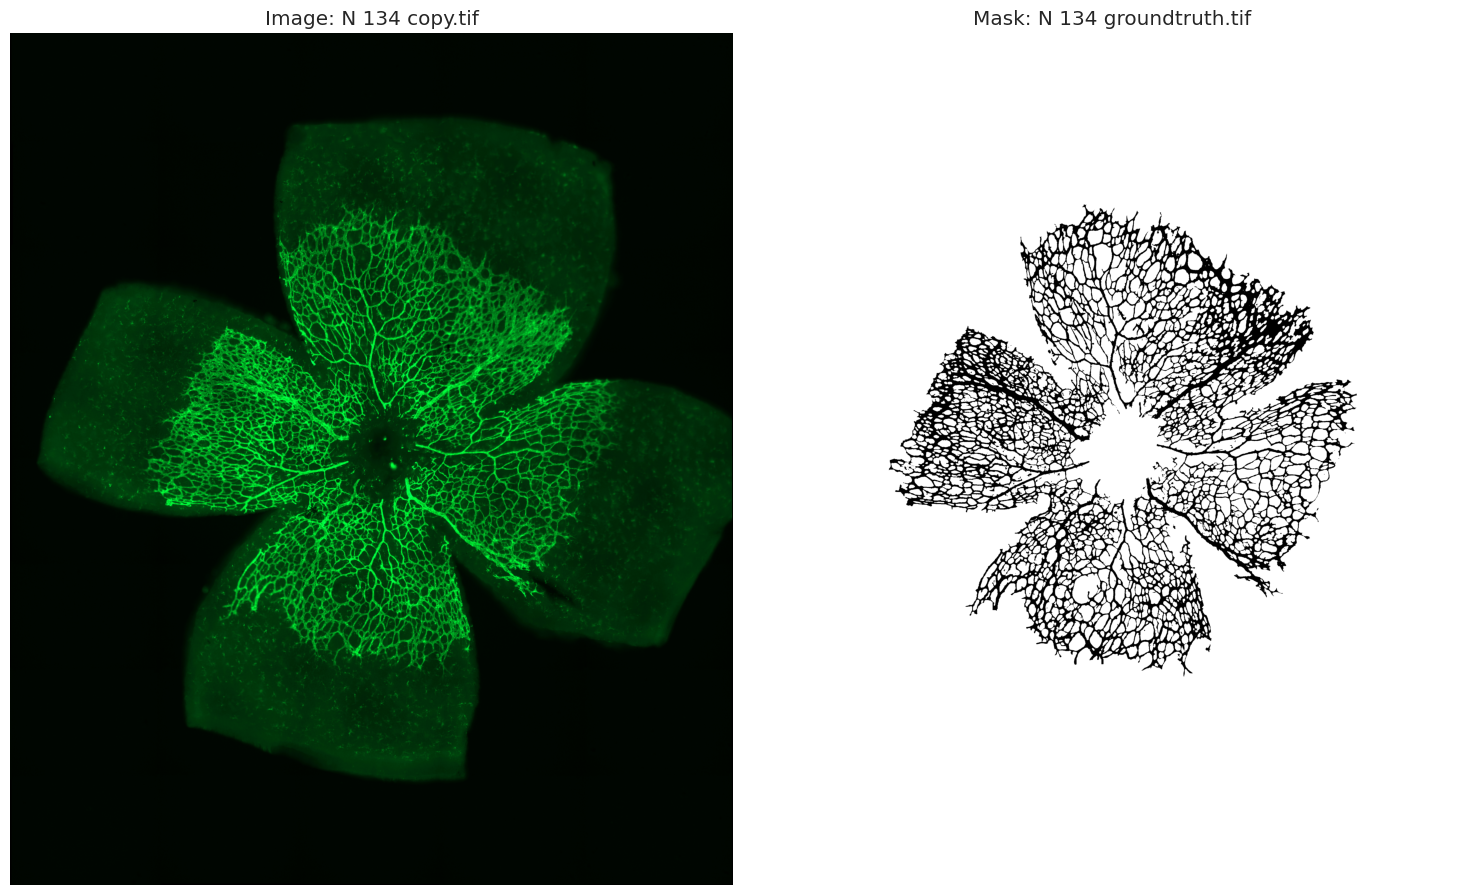

In [6]:
def visualize_samples(image_paths, mask_paths=None, n_samples=4, figsize=(15, 10)):
    """Visualize sample images and their masks side by side"""
    n_samples = min(n_samples, len(image_paths))
    
    if mask_paths:
        fig, axes = plt.subplots(n_samples, 2, figsize=figsize)
        if n_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(n_samples):
            # Load images
            img = load_image(image_paths[i])
            mask = load_image(mask_paths[i])
            
            # Display image
            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title(f'Image: {image_paths[i].name}')
            axes[i, 0].axis('off')
            
            # Display mask
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title(f'Mask: {mask_paths[i].name}')
            axes[i, 1].axis('off')
    else:
        fig, axes = plt.subplots(1, n_samples, figsize=figsize)
        if n_samples == 1:
            axes = [axes]
        
        for i in range(n_samples):
            img = load_image(image_paths[i])
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{image_paths[i].name}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])
visualize_samples(train_images, train_masks, n_samples=1)

[PosixPath('/home/ygao130/Auto/STOR674/Data/train_data/image/N 134 copy.tif')]


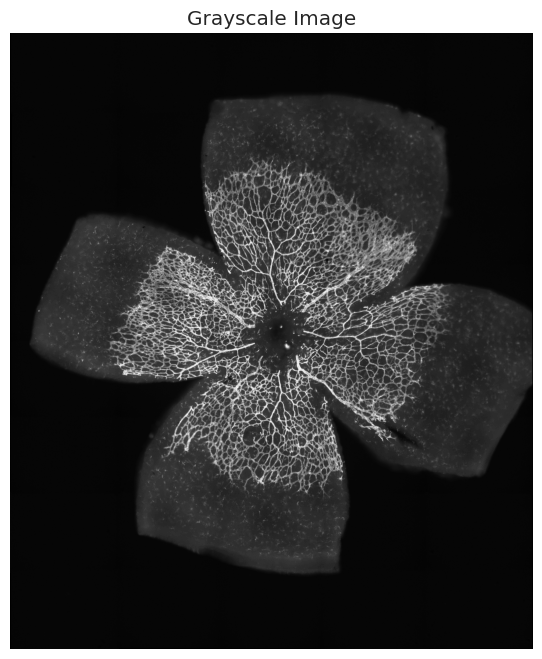

In [71]:
# convert the image to grayscale:
train_images = get_image_list(paths['train_images'])
print(train_images)
img = Image.open(train_images[0])
gray_img = img.convert('L')   # “L” = (8-bit) grayscale mode
gray_img_array = np.array(gray_img)

plt.imshow(gray_img_array, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

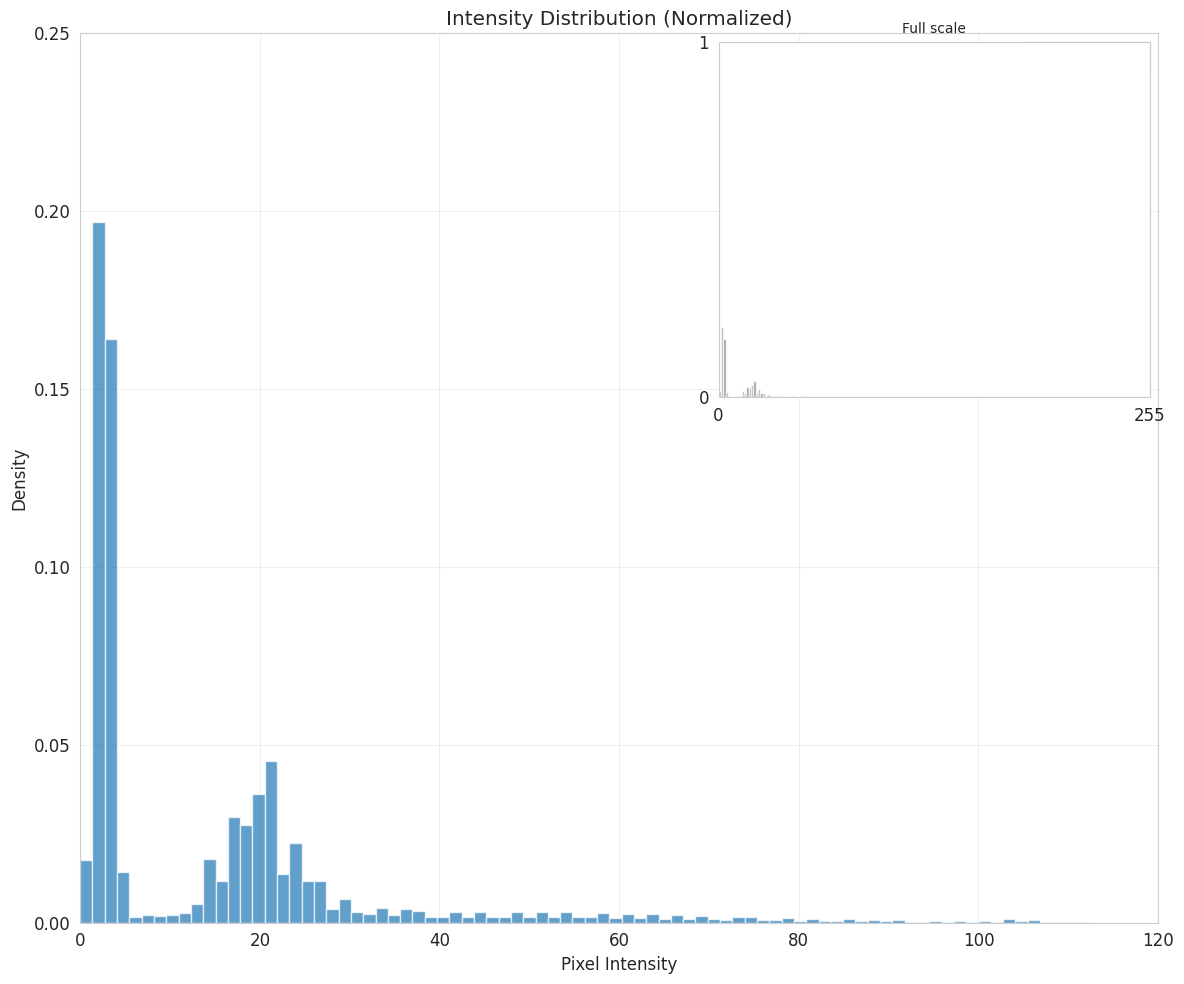

In [6]:
def visualize_intensity_distribution(image_paths, n_samples=5):
    """Visualize intensity adistributions of sample images"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    for i in range(min(n_samples, len(image_paths))):
        img = load_image(image_paths[i])
        # Convert to grayscale if color image
        if len(img.shape) == 3:
            img = np.mean(img, axis=2)
        
        ax.hist(img.flatten(), bins=100, alpha=0.7, 
                label=f'Image {i+1}', density=True)
    
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Density')
    ax.set_title('Intensity Distribution (Normalized)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # can comment this out to only plot intensity
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 0.25)
    # Inset for full range
    axins = inset_axes(ax, width="40%", height="40%", loc='upper right')
    axins.hist(img.flatten(), bins=100, density=True, color='gray', alpha=0.7)
    axins.set_xlim(0, 255)
    axins.set_ylim(0, 1)
    axins.set_xticks([0, 255])
    axins.set_yticks([0, 1])
    axins.set_title("Full scale", fontsize=10)


    plt.tight_layout()    
    plt.show()

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])
visualize_intensity_distribution(train_images, n_samples=1)

In [49]:
# ## Vessel Analysis Functions
def analyze_vessel_coverage(mask_paths, n_samples=None):
    """Analyze the percentage of vessel pixels in masks"""
    if n_samples:
        mask_paths = mask_paths[:n_samples]
    
    vessel_percentages = []
    for mask_path in mask_paths:
        mask = load_image(mask_path)
        # Convert to binary if needed
        if len(np.unique(mask)) > 2:
            mask = (mask > threshold_otsu(mask)).astype(np.uint8)
        vessel_percent = (np.sum(mask > 0) / mask.size) * 100
        vessel_percentages.append(vessel_percent)

    # Print statistics
    print("\nVessel Coverage Statistics:")
    print(f"Mean: {np.mean(vessel_percentages):.2f}%")
    print(f"Median: {np.median(vessel_percentages):.2f}%")
    print(f"Std: {np.std(vessel_percentages):.2f}%")
    print(f"Min: {np.min(vessel_percentages):.2f}%")
    print(f"Max: {np.max(vessel_percentages):.2f}%")
    
    return np.array(vessel_percentages)

train_masks = get_image_list(paths['train_masks'])
vessel_percentages = analyze_vessel_coverage(train_masks)


Vessel Coverage Statistics:
Mean: 92.31%
Median: 92.31%
Std: 0.00%
Min: 92.31%
Max: 92.31%


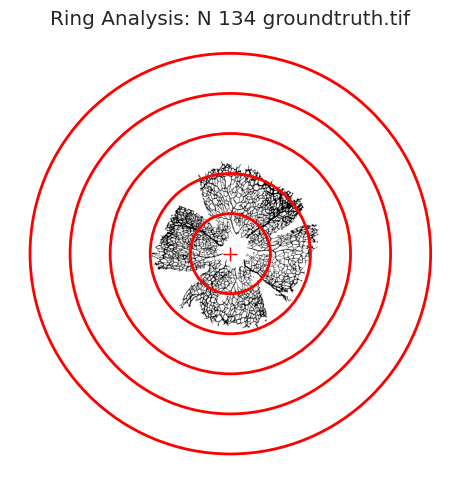

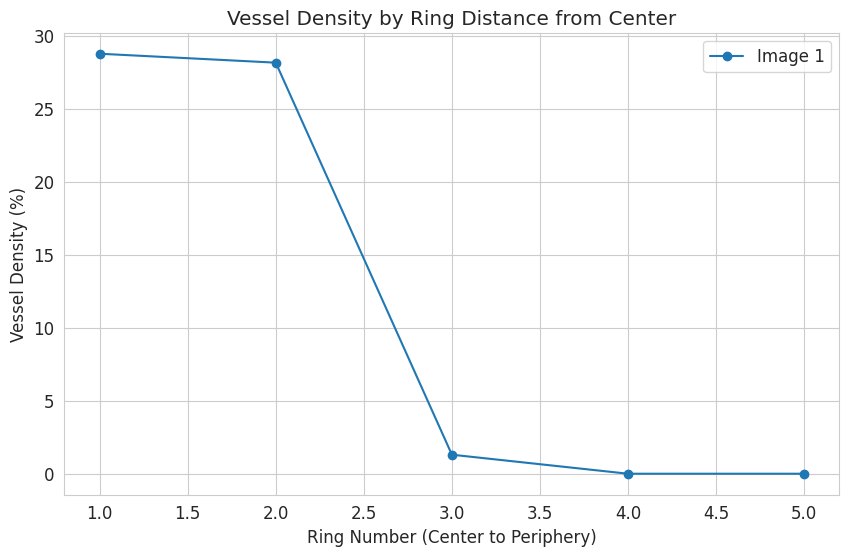

In [15]:
# ## Spatial Analysis

def analyze_spatial_distribution(mask_paths, n_samples=3, n_rings=5):
    """Analyze spatial distribution of vessels using ring-based approach"""
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    if n_samples == 1:
        axes = [axes]
    
    ring_stats = []
    
    for idx, mask_path in enumerate(mask_paths[:n_samples]):
        mask = load_image(mask_path)
        if len(np.unique(mask)) > 2:
            mask = (mask > threshold_otsu(mask)).astype(np.uint8)
        
        # Find center of mass
        center = ndimage.center_of_mass(mask)
        h, w = mask.shape[:2]
        
        # Create rings
        y, x = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        max_dist = np.max(dist_from_center)
        
        # Calculate vessel density in each ring
        ring_densities = []
        ring_boundaries = np.linspace(0, max_dist, n_rings + 1)
        
        for i in range(n_rings):
            ring_mask = (dist_from_center >= ring_boundaries[i]) & \
                       (dist_from_center < ring_boundaries[i + 1])
            # if np.sum(ring_mask) > 0:
            #     density = np.sum(mask[ring_mask]) / np.sum(ring_mask) * 100
            # else:
            #     density = 0
            if mask.dtype == bool:
                density = np.sum(~mask[ring_mask]) / np.sum(ring_mask) * 100  # False = vessels
            else:
                density = np.sum(mask[ring_mask]) / np.sum(ring_mask) * 100
            
            ring_densities.append(density)
        
        ring_stats.append(ring_densities)
        
        # Visualize
        axes[idx].imshow(mask, cmap='gray')
        for i in range(n_rings):
            circle = plt.Circle(center[::-1], ring_boundaries[i+1], 
                              fill=False, color='red', linewidth=2)
            axes[idx].add_patch(circle)
        axes[idx].plot(center[1], center[0], 'r+', markersize=10)
        axes[idx].set_title(f'Ring Analysis: {mask_path.name}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot ring densities
    fig, ax = plt.subplots(figsize=(10, 6))
    ring_stats = np.array(ring_stats)
    x = range(1, n_rings + 1)
    
    for i in range(len(ring_stats)):
        ax.plot(x, ring_stats[i], marker='o', label=f'Image {i+1}')
    
    ax.set_xlabel('Ring Number (Center to Periphery)')
    ax.set_ylabel('Vessel Density (%)')
    ax.set_title('Vessel Density by Ring Distance from Center')
    ax.legend()
    ax.grid(True)
    plt.show()
    
    return ring_stats

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])
ring_stats = analyze_spatial_distribution(train_masks, n_samples=1)

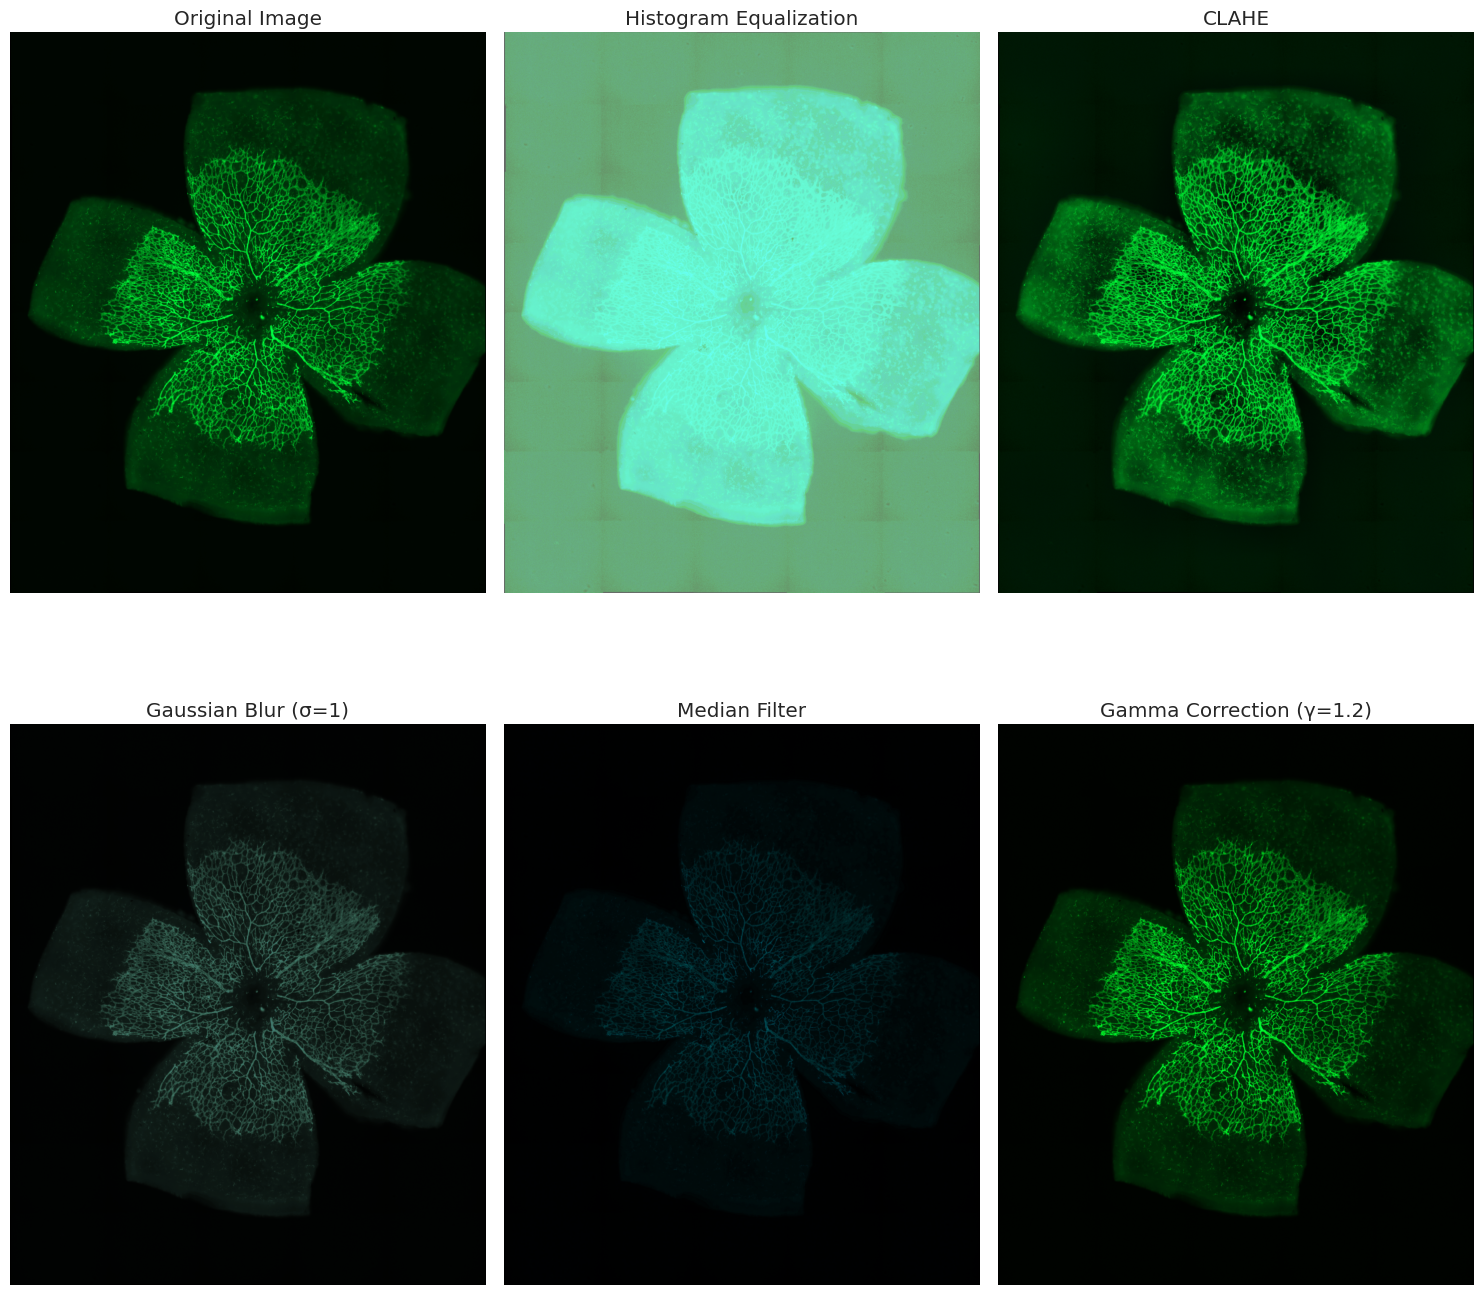

In [53]:
# ## 7. Preprocessing Analysis

def analyze_preprocessing_effects(image_path, mask_path):
    """Analyze effects of different preprocessing techniques"""
    img = load_image(image_path)
    mask = load_image(mask_path)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 15))
    
    # Original
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Histogram equalization
    img_eq = exposure.equalize_hist(img)
    axes[0, 1].imshow(img_eq, cmap='gray')
    axes[0, 1].set_title('Histogram Equalization')
    axes[0, 1].axis('off')
    
    # CLAHE
    img_clahe = exposure.equalize_adapthist(img, clip_limit=0.03)
    axes[0, 2].imshow(img_clahe, cmap='gray')
    axes[0, 2].set_title('CLAHE')
    axes[0, 2].axis('off')
    
    # Gaussian blur
    img_blur = gaussian(img, sigma=1)
    axes[1, 0].imshow(img_blur, cmap='gray')
    axes[1, 0].set_title('Gaussian Blur (σ=1)')
    axes[1, 0].axis('off')
    
    # Median filter
    img_median = ndimage.median_filter(img, size=3)
    axes[1, 1].imshow(img_median, cmap='gray')
    axes[1, 1].set_title('Median Filter')
    axes[1, 1].axis('off')
    
    # Gamma correction
    img_gamma = exposure.adjust_gamma(img, gamma=1.2)
    axes[1, 2].imshow(img_gamma, cmap='gray')
    axes[1, 2].set_title('Gamma Correction (γ=1.2)')
    axes[1, 2].axis('off')
    
    # # Edge detection
    # img_edges = cv2.Canny((img * 255).astype(np.uint8), 50, 150)
    # axes[2, 0].imshow(img_edges, cmap='gray')
    # axes[2, 0].set_title('Edge Detection (Canny)')
    # axes[2, 0].axis('off')
    
    # # Ground truth mask
    # axes[2, 1].imshow(mask, cmap='gray')
    # axes[2, 1].set_title('Ground Truth Mask')
    # axes[2, 1].axis('off')
    
    # # Overlay
    # overlay = np.zeros((*img.shape[:2], 3))
    # overlay[:,:,0] = img / np.max(img)
    # overlay[:,:,1] = mask / np.max(mask)
    # axes[2, 2].imshow(overlay)
    # axes[2, 2].set_title('Overlay (Red: Image, Green: Mask)')
    # axes[2, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])

analyze_preprocessing_effects(train_images[0], train_masks[0])

In [14]:
# CORRECTED VESSEL DETECTION LOGIC
def analyze_vessel_coverage(mask_paths, n_samples=None):
    """Analyze the percentage of vessel pixels in masks"""
    if n_samples:
        mask_paths = mask_paths[:n_samples]
    
    vessel_percentages = []
    for mask_path in mask_paths:
        mask = load_image(mask_path)
        
        # DEBUG: Check mask format
        print(f"Mask dtype: {mask.dtype}")
        print(f"Mask unique values: {np.unique(mask)}")
        print(f"Mean value: {np.mean(mask):.2f}")
        
        # Handle boolean masks correctly
        if mask.dtype == bool:
            # For inverted boolean masks: False = vessels, True = background
            vessel_percent = (np.sum(~mask) / mask.size) * 100  # ~mask inverts True/False
            print("Using logic: np.sum(~mask) for inverted boolean array (False=vessels)")
        else:
            # For numeric masks: determine logic based on mean
            if np.mean(mask) < 128:  # More black pixels than white
                vessel_percent = (np.sum(mask > 0) / mask.size) * 100
                print("Using logic: mask > 0 (black background, white vessels)")
            else:  # More white pixels than black
                vessel_percent = (np.sum(mask == 0) / mask.size) * 100
                print("Using logic: mask == 0 (white background, black vessels)")
        
        vessel_percentages.append(vessel_percent)

    # Print statistics
    print("\nVessel Coverage Statistics:")
    print(f"Mean: {np.mean(vessel_percentages):.2f}%")
    print(f"Median: {np.median(vessel_percentages):.2f}%")
    print(f"Std: {np.std(vessel_percentages):.2f}%")
    print(f"Min: {np.min(vessel_percentages):.2f}%")
    print(f"Max: {np.max(vessel_percentages):.2f}%")
    
    return np.array(vessel_percentages)

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])
analyze_vessel_coverage(train_masks, n_samples=1)


Mask dtype: bool
Mask unique values: [False  True]
Mean value: 0.92
Using logic: np.sum(~mask) for inverted boolean array (False=vessels)

Vessel Coverage Statistics:
Mean: 7.69%
Median: 7.69%
Std: 0.00%
Min: 7.69%
Max: 7.69%


array([7.68701646])

In [13]:
# COMPREHENSIVE MASK ANALYSIS
def analyze_mask_detailed(mask_path):
    """Comprehensive analysis of mask properties"""
    mask = load_image(mask_path)
    
    print("=== COMPREHENSIVE MASK ANALYSIS ===")
    print(f"Mask shape: {mask.shape}")
    print(f"Mask dtype: {mask.dtype}")
    print(f"Unique values: {np.unique(mask)}")
    print(f"Number of unique values: {len(np.unique(mask))}")
    print(f"Min value: {np.min(mask)}")
    print(f"Max value: {np.max(mask)}")
    print(f"Mean value: {np.mean(mask):.2f}")
    print(f"Median value: {np.median(mask):.2f}")
    print(f"Std value: {np.std(mask):.2f}")
    
    # Count pixels by value
    unique_vals, counts = np.unique(mask, return_counts=True)
    print(f"\nPixel value distribution:")
    for val, count in zip(unique_vals, counts):
        percentage = (count / mask.size) * 100
        print(f"  Value {val}: {count} pixels ({percentage:.2f}%)")
    
    
    return mask

# Run the analysis
train_masks = get_image_list(paths['train_masks'])
mask = analyze_mask_detailed(train_masks[0])

=== COMPREHENSIVE MASK ANALYSIS ===
Mask shape: (4080, 3462)
Mask dtype: bool
Unique values: [False  True]
Number of unique values: 2
Min value: False
Max value: True
Mean value: 0.92
Median value: 1.00
Std value: 0.27

Pixel value distribution:
  Value False: 1085788 pixels (7.69%)
  Value True: 13039172 pixels (92.31%)


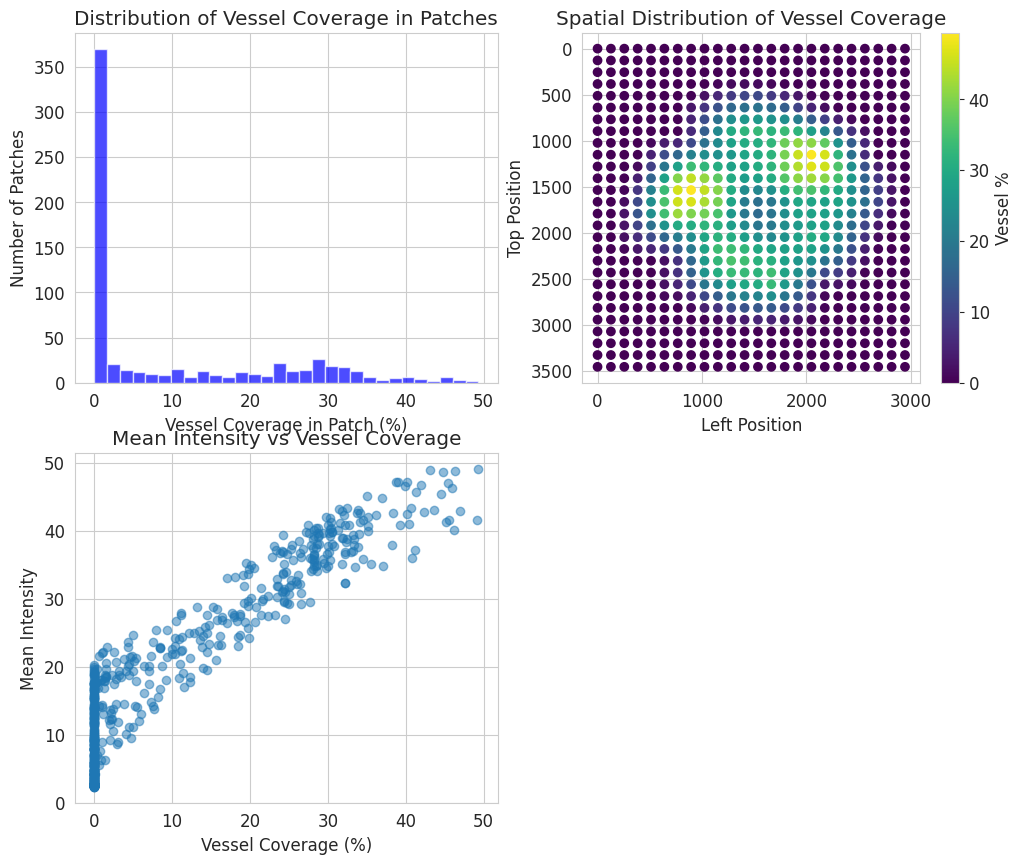

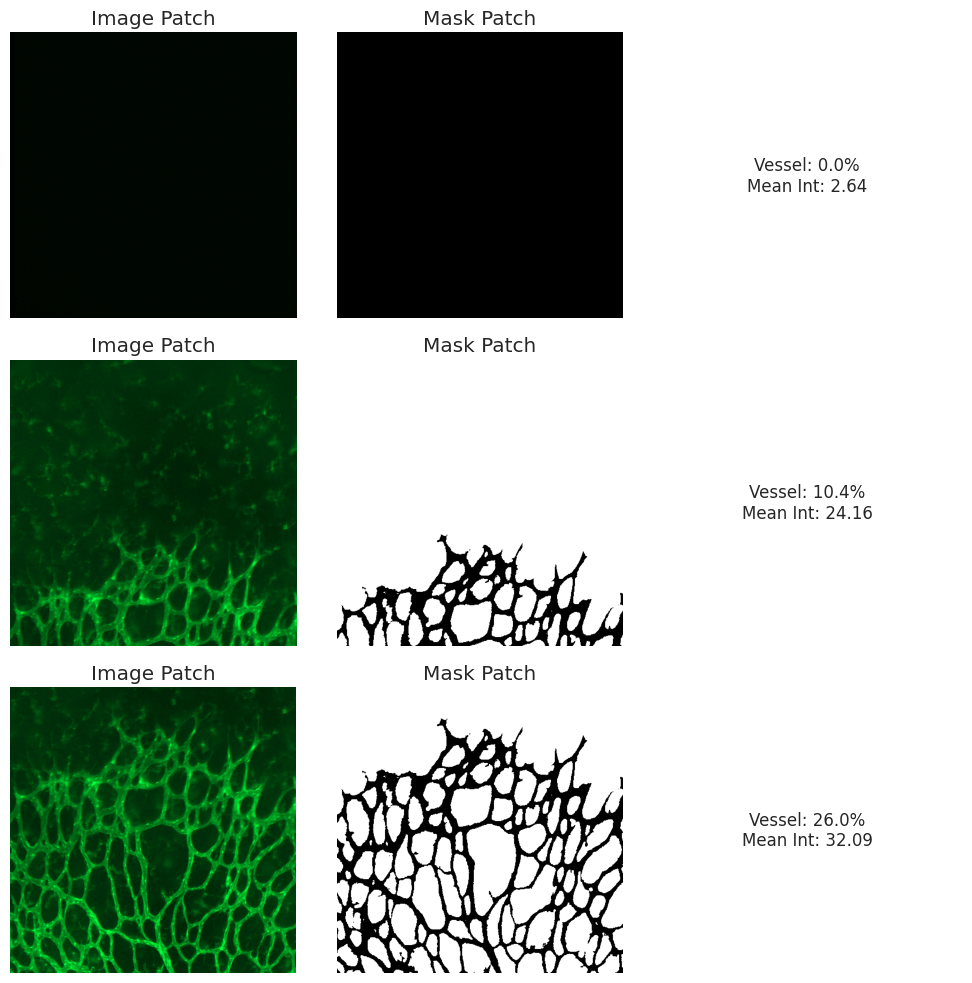


Total patches extracted: 672
Patches with >10% vessels: 237
Patches with >20% vessels: 172


In [16]:
# ## Patch Analysis for Training

def analyze_patch_distribution(image_path, mask_path, patch_size=512, stride=128):
    """Analyze patch extraction for training"""
    img = load_image(image_path)
    mask = load_image(mask_path)
    
    h, w = img.shape[:2]
    patches_info = []
    
    # Extract patches
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch_img = img[i:i+patch_size, j:j+patch_size]
            patch_mask = mask[i:i+patch_size, j:j+patch_size]
            
            # Calculate vessel percentage in patch
            if patch_mask.dtype == bool:
                vessel_percent = np.sum(~patch_mask) / patch_mask.size * 100  # False = vessels
            elif np.mean(patch_mask) < 128:
                vessel_percent = np.sum(patch_mask > 0) / patch_mask.size * 100
            else:
                vessel_percent = np.sum(patch_mask == 0) / patch_mask.size * 100
            
            patches_info.append({
                'top': i,
                'left': j,
                'vessel_percent': vessel_percent,
                'mean_intensity': np.mean(patch_img),
                'std_intensity': np.std(patch_img)
            })
    
    patches_df = pd.DataFrame(patches_info)
    
    # Visualize patch statistics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Vessel percentage distribution
    axes[0, 0].hist(patches_df['vessel_percent'], bins=30, color='blue', alpha=0.7)
    axes[0, 0].set_xlabel('Vessel Coverage in Patch (%)')
    axes[0, 0].set_ylabel('Number of Patches')
    axes[0, 0].set_title('Distribution of Vessel Coverage in Patches')
    
    # Scatter plot of vessel percentage vs position
    scatter = axes[0, 1].scatter(patches_df['left'], patches_df['top'], 
                                c=patches_df['vessel_percent'], cmap='viridis')
    axes[0, 1].set_xlabel('Left Position')
    axes[0, 1].set_ylabel('Top Position')
    axes[0, 1].set_title('Spatial Distribution of Vessel Coverage')
    axes[0, 1].invert_yaxis()
    plt.colorbar(scatter, ax=axes[0, 1], label='Vessel %')
    
    # Mean intensity vs vessel percentage
    axes[1, 0].scatter(patches_df['vessel_percent'], patches_df['mean_intensity'], alpha=0.5)
    axes[1, 0].set_xlabel('Vessel Coverage (%)')
    axes[1, 0].set_ylabel('Mean Intensity')
    axes[1, 0].set_title('Mean Intensity vs Vessel Coverage')
    
    # Example patches
    ax = axes[1, 1]
    ax.axis('off')
    
    # Show some example patches
    n_examples = 6
    example_indices = [
        patches_df[patches_df['vessel_percent'] < 5].index[0] if len(patches_df[patches_df['vessel_percent'] < 5]) > 0 else 0,  # Low vessel
        patches_df[(patches_df['vessel_percent'] > 10) & (patches_df['vessel_percent'] < 20)].index[0] if len(patches_df[(patches_df['vessel_percent'] > 10) & (patches_df['vessel_percent'] < 20)]) > 0 else 1,  # Medium vessel
        patches_df[patches_df['vessel_percent'] > 25].index[0] if len(patches_df[patches_df['vessel_percent'] > 25]) > 0 else 2  # High vessel
    ]
    
    fig2, axes2 = plt.subplots(len(example_indices), 3, figsize=(10, 10))
    for idx, patch_idx in enumerate(example_indices):
        patch_info = patches_df.iloc[patch_idx]
        i, j = int(patch_info['top']), int(patch_info['left'])
        
        patch_img = img[i:i+patch_size, j:j+patch_size]
        patch_mask = mask[i:i+patch_size, j:j+patch_size]
        
        axes2[idx, 0].imshow(patch_img, cmap='gray')
        axes2[idx, 0].set_title(f'Image Patch')
        axes2[idx, 0].axis('off')
        
        axes2[idx, 1].imshow(patch_mask, cmap='gray')
        axes2[idx, 1].set_title(f'Mask Patch')
        axes2[idx, 1].axis('off')
        
        axes2[idx, 2].text(0.5, 0.5, f'Vessel: {patch_info["vessel_percent"]:.1f}%\nMean Int: {patch_info["mean_intensity"]:.2f}', 
                          ha='center', va='center', fontsize=12)
        axes2[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return patches_df

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])

patches_df = analyze_patch_distribution(train_images[0], train_masks[0])
print(f"\nTotal patches extracted: {len(patches_df)}")
print(f"Patches with >10% vessels: {len(patches_df[patches_df['vessel_percent'] > 10])}")
print(f"Patches with >20% vessels: {len(patches_df[patches_df['vessel_percent'] > 20])}")